# apex_converter.py
## Demonstration and Interactive Documentation
This document will demonstrate how to quickly convert large sets of geographic-coordinate data into Modified Apex Coordinates.

## Requirements:
+ Python >=2.7 and < 3.0 
+ Python Modules:
    + Numpy (tested with v. 1.7)
    + Matplotlib (tested with v. 1.5)
    
+ For Interactive Demo and Test: Jupyter Notebook
    
This code has been tested on Ubuntu Linux 14.04 and has been installed on OSX using system python. Not yet tested on Windows. 

## Contact:
Please report any compatability issues or bugs to:  
Liam Kilcommons <liam.kilcommons@colorado.edu>

## Notes:
To install and compile the python interface, it should only be nessecary to issue:
`python setup.py install`
in a shell from the root directory of the apex codebase.


In [1]:
#Make sure apex python bindings are installed correctly 
#by importing the module. If you would like to further 
#test your apex installation, you can run the unit tests for
#the apex python bindings by issuing python test_apxntrp 
#from your command window or shell in the src 
#subdirectory of the apex codebase
import apexpython
#This module is needed for displaying the docstrings prettily
import textwrap
#This 'magic' function ensures that the code is 
#running the newest version
%load_ext autoreload
%autoreload 2

## Instantiating the Apex Converter

By creating an apex_converter object, you initialize and store in memory a global grid of points mapping geographic to magnetic coordinates. Interpolation between adjacent points is used to determine the apex location of a particular geographic input. Passing optional parameters allows you to change the extent and resolution of the grid. The epoch parameter dictates the epoch for choosing IGRF coefficients to use for determining the geomagnetic field. Information about the class and the parameters you can set at instantiation can be found in the docstring below.


In [2]:
#Import the apex_converter module
from apexpython import apex_converter

In [3]:

#Make a converter object
#-----------------------
converter = apex_converter.apex_converter()

Initializing lat,lon,alt grid with following parameters:

Epoch, Nvert = 2010.000000, 50.000000

Lat min,max,npts = -90.000000,90.000000,151.000000

Lon min,max,npts = -180.000000,180.000000,251.000000

Alt min,max,npts = 300.000000,900.000000,6.000000

Preparing interpolation tables...


## Apex Converter Conversion Operations

Apex Converter primarily uses the APXMALL fortran subroutine, which fetches almost all possible information about a particular geographic location. This includes the geomagnetic field at the location, the apex latitude and longitude at the location, the quasi-dipole latitude at the location, and the various apex basis vectors, expressed in geographic east,north,up coordinates.  

The apex_converter has methods for the following tasks:  

+ Converting a numpy array of latitude, longitude, altitude points to corresponding Modified Apex locations (_geo2apex()_)
+ Converting a numpy array of Apex Longitude to Magnetic Local Time (MLT) (_alon2mlt()_)
+ Converting a vector measurement in geographic (east,north,up) made at a geographic location lat,lon,alt to the correspond Modified Apex vector (d1,d2,d3) and location (alat,alon,mlt) (_measurement2apex()_)

The best way to learn about these methods is to view their docstrings (python's internal documentation for methods/functions). This code attempts to follow the spirit of the [numpy docstring guidelines](https://github.com/numpy/numpy/blob/master/doc/HOWTO_DOCUMENT.rst.txt):

In [4]:
print textwrap.dedent(converter.geo2apex.__doc__)
#textwrap.dedent removes any tabs in the docstring which would make it hard to read
#when it's displayed here


Does a simple transformation of observation positions from geographic to apex

Parameters
----------
lat : numpy.array
	Observation Geographic latitudes
lon : numpy.array
	Observation Geographic longitudes
alt : numpy.array
	Observation Altitudes in km
hr=110. : float
	Modified Apex reference height in km

Returns
-------
alat : numpy.array
	Modified Apex Latitude
alon : numpy.array
	Apex Longitude
qdlat : numpy.array
	Quasi-Dipole Latitude



In [5]:
print textwrap.dedent(converter.alon2mlt.__doc__)


Converts Apex Longitudes to Magnetic Local Time

Calls apex subroutine apex.magloctm (mag local time)
after setting the IGRF coefficient global variables using
the same epoch as was used to initially
generate the interpolation tables.

Parameters
----------
alon : numpy.array
	a numpy array of length n, apex longitude
year : int or numpy.array
	The year for which to compute the MLT
dayofyear : int or numpy.array
	The day-of-year(s) for which MLT is to be found
utseconds : int or numpy.array
	the second-of-the-day(s) in UT
	of the time for which the MLT is to be found

Returns
-------
mlt : numpy.array
	The magnetic local time corresponding to alon for
	the times specified

Notes
-----
	Options for time argument (year,dayofyear,utseconds) length

	#. All have length 1 for MLT of all alons for a fixed time.
	#. Year,and Day of year can have length 1, and then UT seconds can have length n for different times on same day
	#. All can have length n to find the MLT of each alon with a unique

In [6]:
print textwrap.dedent(converter.measurement2apex.__doc__)


Converts a vector measurement and it's associated location to modified apex coordinates

Transforms measurement vector v [m x 3] in geo east, north, up
to apex. Lat, lon, and alt are [m x 1] vectors of locations association with
Measurements in vector v, hr is reference height

Parameters
----------
lat : numpy.array
	geographic latitude
lon : numpy.array
	geographic longitude
alt : numpy.array
	geographic altitude
v : numpy.array
	[nx3] vector to transform
hr : float, optional
	Apex reference height in km (default=110.)

Returns
-------
alat : numpy.array
	Modified Apex Latitude of measurement
alon : numpy.array
	Apex Longitude of measurement
v_d : numpy.array
	Vector in Apex 'd' basis




## Converting real observational data points
The apex converter software is fully vectorized and can convert large numbers of geographic ephemerides or ephemeris-vector combinations.

This example will use a small sample (500 pts) of data from the [NASA ST5 mission](http://www.nasa.gov/mission_pages/st-5/spacecraft/index.html). The orbit of this spacecraft is highly elliptical, with a periapse of around 300 km, and an apoapse of around 4500 km. This provides a bit of a challenge for bulk apex conversion because it requires a very large vertical range. Also, the accuracy of the IGRF field model is lower at higher altitude because of the greater succeptibilty to perturbation of the field at this altitude.

    IMPORTANT: To run this part of the code you will need some extra plotting routines (satplottools). 
    You can get these by installing this library:
    https://github.com/lkilcommons/geospacepy-lite

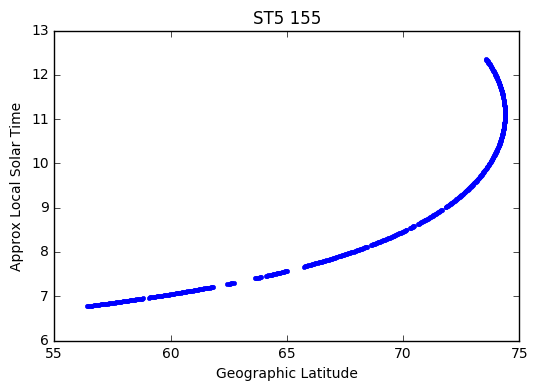

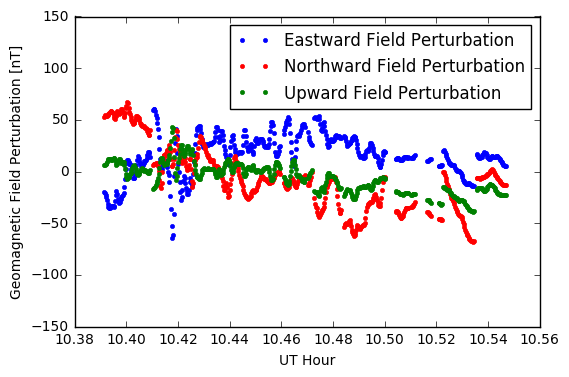

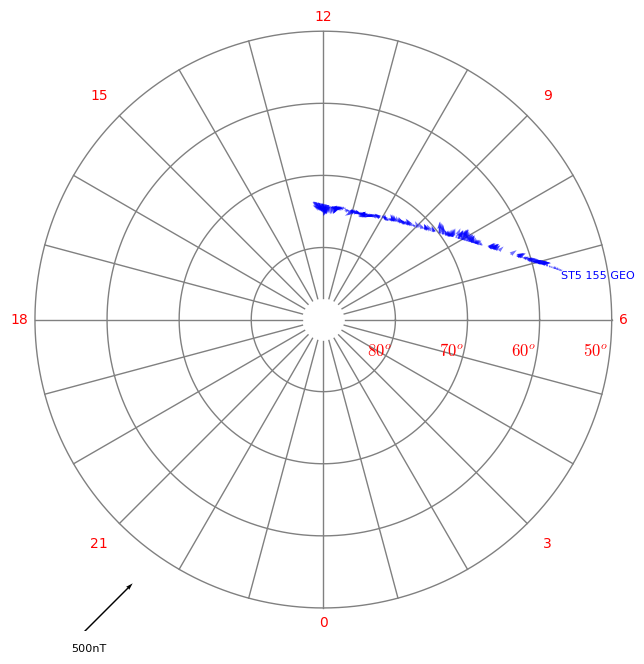

In [7]:
import datetime
import matplotlib.pyplot as pp
from geospacepy import satplottools
import numpy
data = numpy.genfromtxt('st5_155_test.txt',delimiter=',')
#Load up the data from a comma-seperated text file and splice out the appropriate variables 
year = data[:,0]
month = data[:,1]
day = data[:,2]
hour  = data[:,3]
minute = data[:,4]
second = data[:,5]
MLT = data[:,6] 
B_GEO = data[:,10:13]
IGRF_B_GEO = data[:,22:25]
R_GEO = numpy.column_stack((data[:,35],data[:,36],data[:,34])) 
#lat,lon 
lat = R_GEO[:,0]
lon = R_GEO[:,1]
#Convert to -180 to 180 longitude instead of 0 to 360 
lon[lon>180.] = lon[lon>180.]-360.

#Compute the day of year
date2doy = lambda y,mo,d,h,m,s: float(datetime.datetime(y,mo,d,h,m,s).timetuple().tm_yday)
dayofyear = date2doy(int(year[0]),int(month[0]),int(day[0]),0,0,0)

#Compute the second of the day
secofday = second+minute*60.+hour*3600.

#Estimate the local solar time
lst = secofday/3600. + lon/180.*12. 

#Convert radius to altitude using an older standard radius, 
#but the one that is used in the apex fortran code
Re = 6371.2 #km
alt = (R_GEO[:,2]-1.)*(Re)

#Show the sample ephemeris
f1 = pp.figure()
ax = pp.axes()
ax.plot(lat,lst,'b.')
ax.set_xlabel('Geographic Latitude')
ax.set_ylabel('Approx Local Solar Time')
ax.set_title('ST5 155')

#Compute the magnetic perturbation by subtracting the main-field model value
dB_GEO_east = B_GEO[:,0]-IGRF_B_GEO[:,0]
dB_GEO_north = B_GEO[:,1]-IGRF_B_GEO[:,1]
dB_GEO_up = B_GEO[:,2]-IGRF_B_GEO[:,2]
dB_GEO = numpy.column_stack((dB_GEO_east,dB_GEO_north,dB_GEO_up))

f2 = pp.figure()
ax2 = pp.axes()
ax2.plot(secofday/3600,dB_GEO_east,'b.',label='Eastward Field Perturbation')
ax2.plot(secofday/3600,dB_GEO_north,'r.',label='Northward Field Perturbation')
ax2.plot(secofday/3600,dB_GEO_up,'g.',label='Upward Field Perturbation')
ax2.set_ylabel('Geomagnetic Field Perturbation [nT]')
ax2.set_xlabel('UT Hour')
ax2.set_ylim([-150,150])
ax2.legend()

f22 = pp.figure(figsize=(8,8))
ax22 = pp.axes()
vplotdata_geo = numpy.column_stack((secofday,lat,lst,dB_GEO[:,0],dB_GEO[:,1]))
satplottools.draw_dialplot(ax22)
satplottools.vector_plot(ax22,vplotdata_geo,satname='ST5 155 GEO',latlim=50.,max_magnitude=500.)
pp.show()

In [8]:
#Make an apex converter with fairly high resolution
#(see section titled 'Initialize Apex Converter')
st5converter = apex_converter.apex_converter(epoch=2006.,nvert=40.,altmin=100.,altmax=4000.)

#Convert the measurement to apex coordinates using a reference height of 110 km.

alat,alon,dB_apex = st5converter.measurement2apex(lat,lon,alt,dB_GEO)

#Convert apex longitude to magnetic local time
mlt = st5converter.alon2mlt(alon,2006.,dayofyear,secofday)

Initializing lat,lon,alt grid with following parameters:

Epoch, Nvert = 2006.000000, 40.000000

Lat min,max,npts = -90.000000,90.000000,121.000000

Lon min,max,npts = -180.000000,180.000000,201.000000

Alt min,max,npts = 100.000000,4000.000000,17.000000

Preparing interpolation tables...
Transforming 500 points from lat,lon,alt to apex...
Computing 500 Apex Longitude values to Magnetic Local Time...



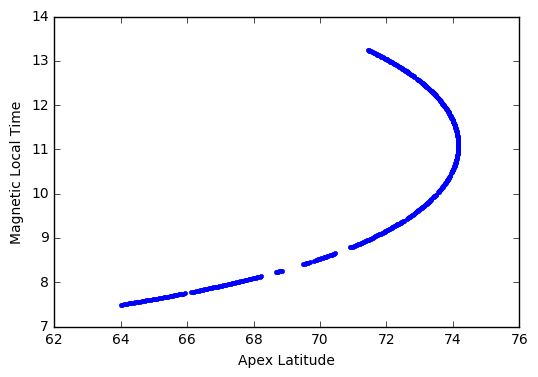

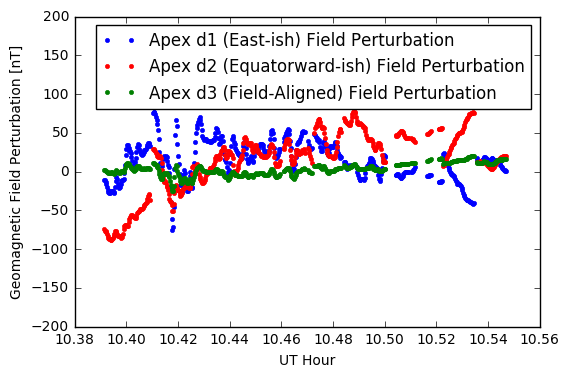

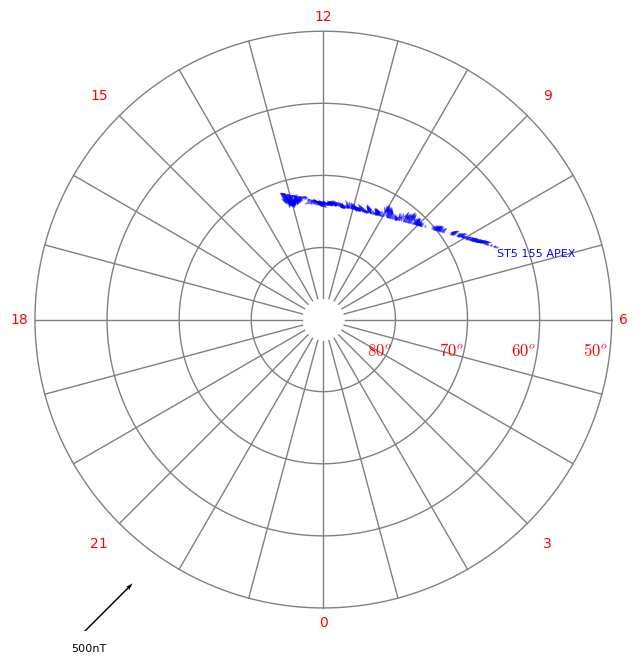

In [9]:
f3 = pp.figure()
ax3 = pp.axes()
ax3.plot(alat,mlt,'b.',label='ST5 155 Track, Apex')
ax3.set_xlabel('Apex Latitude')
ax3.set_ylabel('Magnetic Local Time')

f4 = pp.figure()
ax4 = pp.axes()
ax4.plot(secofday/3600,dB_apex[:,0],'b.',label='Apex d1 (East-ish) Field Perturbation')
ax4.plot(secofday/3600,dB_apex[:,1],'r.',label='Apex d2 (Equatorward-ish) Field Perturbation')
ax4.plot(secofday/3600,dB_apex[:,2],'g.',label='Apex d3 (Field-Aligned) Field Perturbation')
ax4.set_ylabel('Geomagnetic Field Perturbation [nT]')
ax4.set_xlabel('UT Hour')
ax4.set_ylim([-200,200])
ax4.legend()

f5 = pp.figure(figsize=(8,8))
ax5 = pp.axes()
vplotdata_apex = numpy.column_stack((secofday,alat,mlt,dB_apex[:,0],-1*dB_apex[:,1]))
satplottools.draw_dialplot(ax5)
satplottools.vector_plot(ax5,vplotdata_apex,satname='ST5 155 APEX',latlim=50.,max_magnitude=500.)
pp.show()